# Titanic Survivors Data Classification

#### To Do
- Optimize Age Segmentation
- Choose which "family" features to keep or remove
- Check if cabin letter is correlated with survival
- Create Pipelines (with scaling as needed)
- Do Xtrain,Xtest normalization seperately
- Try geometric mean in ensemble
- Try stacking and blending

In [30]:
#######################################
### Import Data Processing Packages ###
#######################################

import pandas            as pd;
import numpy             as np;
import seaborn           as sns;
import matplotlib.pyplot as plt;

%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

########################################
### Import Machine Learning Packages ###
########################################

from sklearn.preprocessing   import StandardScaler;
from sklearn.preprocessing   import PolynomialFeatures;

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV;
from sklearn.metrics         import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error;

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis;
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis;

from sklearn.naive_bayes     import GaussianNB

from sklearn.linear_model    import LinearRegression;
from sklearn.linear_model    import LogisticRegression;
from sklearn.linear_model    import Ridge;
from sklearn.linear_model    import Lasso;

from sklearn.neighbors       import KNeighborsClassifier;
from sklearn.tree            import DecisionTreeClassifier;
from sklearn.ensemble        import RandomForestClassifier;
from sklearn.svm             import SVC;
from sklearn.cluster         import KMeans;
from sklearn.decomposition   import PCA;

from sklearn.neural_network  import MLPClassifier;

from sklearn.pipeline import Pipeline;

import xgboost as xgb;

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam ,RMSprop
from keras.utils.np_utils import to_categorical

########################
### Import Data Sets ###
########################

from sklearn                 import datasets;

Using Theano backend.


In [2]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

# Convert to Pandas
#df = pd.DataFrame(data=np.c_[digits['data'], digits['target']], columns=np.append(digits['feature_names'], 'target'))
#df = pd.DataFrame(data=np.c_[digits['data'], digits['target']], columns=np.append(np.arange(1, 65, 1), 'target'))

In [29]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [25]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [26]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [27]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [28]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [29]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [30]:
train_df[["Embarked", "Survived"]].dropna().groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [50]:
# Check for null entries
print(train_df.isnull().any())
print('\n')
print(test_df.isnull().any())

Survived      False
Pclass        False
Sex           False
Age            True
SibSp         False
Parch         False
Fare          False
Embarked      False
FamilySize    False
IsAlone       False
Title         False
dtype: bool


Pclass        False
Sex           False
Age            True
SibSp         False
Parch         False
Fare          False
Embarked      False
FamilySize    False
IsAlone       False
Title         False
dtype: bool


In [4]:
#####################
### Preprocessing ###
#####################

test_df = pd.read_csv('test.csv')

passengerid = test_df['PassengerId']

# Create New Features
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

test_df['IsAlone'] = 0
test_df.loc[test_df['FamilySize'] == 1, 'IsAlone'] = 1

test_df['Title'] = test_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
test_df['Title'] = test_df['Title'].map(title_mapping)
test_df['Title'] = test_df['Title'].fillna(0)

test_df['AgeBand'] = pd.cut(test_df['Age'], 5)
test_df.loc[ test_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 32), 'Age'] = 1
test_df.loc[(test_df['Age'] > 32) & (test_df['Age'] <= 48), 'Age'] = 2
test_df.loc[(test_df['Age'] > 48) & (test_df['Age'] <= 64), 'Age'] = 3
test_df.loc[ test_df['Age'] > 64, 'Age']
test_df = test_df.drop(['AgeBand'], axis=1)

# Remove Complicated Text Columns
test_df = test_df.drop(['Name', 'Ticket', 'PassengerId', 'Cabin', 'SibSp', 'Parch', 'IsAlone'], axis=1)

# Change Sex Column to Quantitative Data
test_df['Sex']  = test_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# Fill NaN with Median/Mode
test_df['Age'] = test_df['Age'].fillna(np.median(test_df['Age'].dropna()))

test_df['Fare'] = test_df['Fare'].fillna(np.median(test_df['Fare'].dropna()))

freq_port = test_df.Embarked.dropna().mode()[0]
test_df['Embarked'] = test_df['Embarked'].fillna(freq_port)
test_df['Embarked'] = test_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Check Head

test_df.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,3,0,2.0,7.8292,2,1,1
1,3,1,2.0,7.0000,0,2,3
2,2,0,3.0,9.6875,2,1,1
3,3,0,1.0,8.6625,0,1,1
4,3,1,1.0,12.2875,0,3,3


In [3]:
#####################
### Preprocessing ###
#####################

train_df = pd.read_csv('train.csv')

# Create New Features
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1

train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train_df['Title'] = train_df['Title'].map(title_mapping)
train_df['Title'] = train_df['Title'].fillna(0)

train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df.loc[ train_df['Age'] <= 16, 'Age'] = 0
train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 32), 'Age'] = 1
train_df.loc[(train_df['Age'] > 32) & (train_df['Age'] <= 48), 'Age'] = 2
train_df.loc[(train_df['Age'] > 48) & (train_df['Age'] <= 64), 'Age'] = 3
train_df.loc[ train_df['Age'] > 64, 'Age']
train_df = train_df.drop(['AgeBand'], axis=1)
    
# Remove Complicated Text Columns
train_df = train_df.drop(['Name', 'Ticket', 'PassengerId', 'Cabin', 'SibSp', 'Parch', 'IsAlone'], axis=1)

# Change Sex Column to Quantitative Data
train_df['Sex'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# Fill NaN with Median/Mode
train_df['Age'] = train_df['Age'].fillna(np.median(train_df['Age'].dropna()))

train_df['Fare'] = train_df['Fare'].fillna(np.median(train_df['Fare'].dropna()))

freq_port = train_df.Embarked.dropna().mode()[0]
train_df['Embarked'] = train_df['Embarked'].fillna(freq_port)
train_df['Embarked'] = train_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Check Head

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,0,1.0,7.2500,0,2,1
1,1,1,1,2.0,71.2833,1,2,3
2,1,3,1,1.0,7.9250,0,1,2
3,1,1,1,2.0,53.1000,0,2,3
4,0,3,0,2.0,8.0500,0,1,1


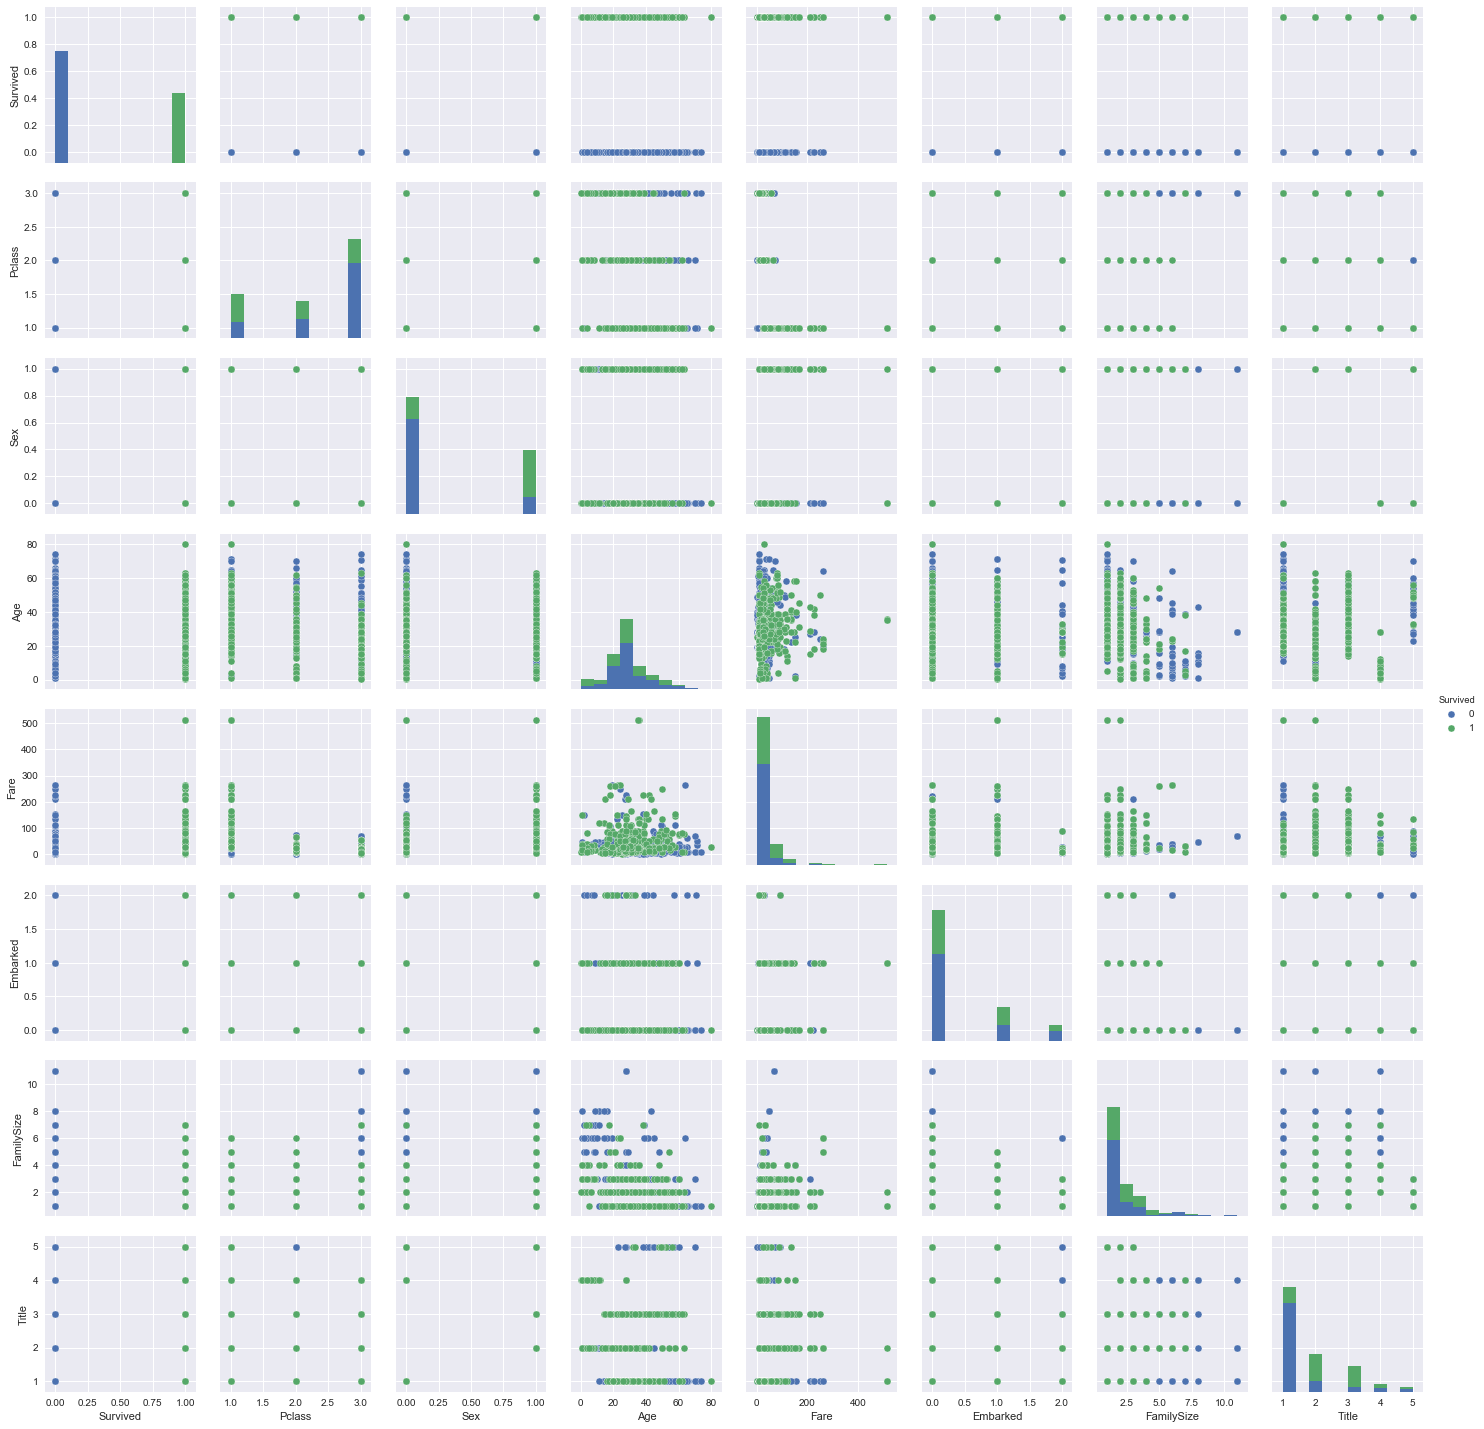

In [77]:
sns.pairplot(data=train_df, hue='Survived')

# Scale and Train,Test,Split

In [5]:
# Scale features to mean = 1, std = 1

train_scaler = StandardScaler();
test_scaler  = StandardScaler();

train_scaler.fit(train_df.drop('Survived', axis=1));
test_scaler.fit(test_df);

scaled_train = train_scaler.transform(train_df.drop('Survived', axis=1));
scaled_test  = test_scaler.transform(test_df);

df_feat = pd.DataFrame(scaled_test, columns=train_df.columns[1:])
df_feat.describe()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
count,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02
mean,-2.018587e-17,-1.859225e-17,-4.568382e-17,8.154030e-17,-2.231070e-17,-9.189884e-17,7.224418e-17
std,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00
min,-1.505120e+00,-7.559289e-01,-3.312800e-01,-6.377637e-01,-6.778412e-01,-5.534426e-01,-7.380199e-01
25%,-1.505120e+00,-7.559289e-01,-1.276402e-01,-4.962194e-01,-6.778412e-01,-5.534426e-01,-7.380199e-01
50%,8.734819e-01,-7.559289e-01,-1.276402e-01,-3.786501e-01,-6.778412e-01,-5.534426e-01,-7.380199e-01
75%,8.734819e-01,1.322876e+00,7.599953e-02,-7.358230e-02,7.826620e-01,1.056429e-01,2.571166e-01
max,8.734819e-01,1.322876e+00,1.514534e+01,8.546519e+00,2.243165e+00,6.037412e+00,3.242526e+00


In [6]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train, train_df['Survived'], test_size=0.1);
#X_train, X_test, y_train, y_test = train_test_split(train_df.drop('Survived', axis=1), train_df['Survived'], test_size=0.1);

# K Nearest Neighbors

In [7]:
knn = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

knn.fit(X_train,y_train);

pred = knn.predict(X_test);
pred_knn = knn.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(knn, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[50  6]
 [12 22]]


Classification Report
             precision    recall  f1-score   support

          0       0.81      0.89      0.85        56
          1       0.79      0.65      0.71        34

avg / total       0.80      0.80      0.80        90



Cross Validation Scores
Accuracy: 0.81 (+/- 0.07)


In [21]:
param_grid = [{'n_neighbors': np.arange(1, 10),
               'weights':     ['uniform', 'distance'],
               'algorithm':   ['ball_tree', 'kd_tree', 'brute']
              }]

grid = GridSearchCV(knn, param_grid, cv=10)

grid.fit(X_train, y_train)

print('Best Score')
print(grid.best_score_)
print('\n')

#print('Mean Test Standard Deviations')
#print(grid.cv_results_['std_train_score'])
#print('\n')

print('Best Estimator')
grid.best_estimator_

Best Score
0.794007490637


Best Estimator


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [8]:
knn.fit(scaled_train, train_df['Survived'].values)

submission_knn = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": knn.predict(test_df.values)
    })

#submission.to_csv('submissions/knn_submission.csv', index=False)

In [69]:
print('Score = ' + str(0.61) + ' with no feature engineering')

print('Score = ' + str(0.56) + ' with feature engineering')

Score = 0.61with no feature engineering
Score = 0.56with feature engineering


# Decision Tree

In [9]:
dtree = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

dtree.fit(X_train, y_train);

pred = dtree.predict(X_test);
pred_dtree = dtree.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(dtree, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[43 13]
 [12 22]]


Classification Report
             precision    recall  f1-score   support

          0       0.78      0.77      0.77        56
          1       0.63      0.65      0.64        34

avg / total       0.72      0.72      0.72        90



Cross Validation Scores
Accuracy: 0.81 (+/- 0.08)


In [24]:
param_grid = [{'criterion': ['gini', 'entropy'],
               'splitter':  ['best', 'random'],
               'max_features':  ['sqrt', 'log2', None],
               'class_weight': [None, 'balanced']
              }]

grid = GridSearchCV(dtree, param_grid, cv=10)

grid.fit(X_train, y_train)

print('Best Score')
print(grid.best_score_)
print('\n')

#print('Mean Test Standard Deviations')
#print(grid.cv_results_['std_train_score'])
#print('\n')

print('Best Parameters')
grid.best_params_

print('Best Estimator')
grid.best_estimator_

Best Score
0.816479400749


Best Parameters
Best Estimator


DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [26]:
submission = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": dtree.predict(test_df.values)
    })
#submission.to_csv('submissions/dtree_submission.csv', index=False)

In [27]:
print('Score = ' + str(0.36) + ' with no feature engineering')

print('Score = ' + str(0.77) + ' with larger test size, simplified features to reduce overfitting')

Score = 0.36 with no feature engineering
Score = 0.77 with larger test size, simplified features to reduce overfitting


# Random Forest

In [10]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

rfc.fit(X_train, y_train);

pred = rfc.predict(X_test);
pred_rfc = rfc.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(rfc, scaled_train, train_df['Survived'],  cv=5)
#scores = cross_val_score(rfc, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[48  8]
 [13 21]]


Classification Report
             precision    recall  f1-score   support

          0       0.79      0.86      0.82        56
          1       0.72      0.62      0.67        34

avg / total       0.76      0.77      0.76        90



Cross Validation Scores
Accuracy: 0.81 (+/- 0.04)


In [36]:
param_grid = [{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               'criterion': ['gini', 'entropy'],
               'max_features':  ['sqrt', 'log2', None],
               'class_weight': [None, 'balanced']
              }]

grid = GridSearchCV(rfc, param_grid, cv=10)

grid.fit(scaled_train, train_df['Survived'].values)

print('Best Score')
print(grid.best_score_)
print('\n')

#print('Mean Test Standard Deviations')
#print(grid.cv_results_['std_train_score'])
#print('\n')

print('Best Parameters')
grid.best_params_

print('Best Estimator')
grid.best_estimator_

Best Score
0.826038159371


Best Parameters
Best Estimator


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [11]:
rfc.fit(scaled_train, train_df['Survived'].values)

submission_rfc = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": rfc.predict(scaled_test)
    })

#submission.to_csv('submissions/rfc_submission.csv', index=False)

In [42]:
print('Score = ' + str(0.63) + ' with no feature engineering')

print('Score = ' + str(0.39) + ' with some feature engineering')

print('Score = ' + str(0.77) + ' with larger test size, simplified features to reduce overfitting')

print('Score = ' + str(0.74) + ' with scaling')

Score = 0.63 with no feature engineering
Score = 0.39 with some feature engineering
Score = 0.77 with larger test size, simplified features to reduce overfitting
Score = 0.74 with scaling


# XGBoost

In [12]:
gbm = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=80, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

gbm.fit(X_train, y_train)

pred = gbm.predict(X_test)
pred_gbm = gbm.predict(X_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(gbm, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[48  8]
 [10 24]]


Classification Report
             precision    recall  f1-score   support

          0       0.83      0.86      0.84        56
          1       0.75      0.71      0.73        34

avg / total       0.80      0.80      0.80        90



Cross Validation Scores
Accuracy: 0.85 (+/- 0.08)


In [57]:
np.linspace(20, 200, 10)

array([  20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.,  200.])

In [59]:
param_grid = [{'max_depth': np.linspace(1, 5, 5, dtype=int),
               'n_estimators': np.linspace(20, 200, 10, dtype=int),
               'learning_rate': np.linspace(0.1, 1, 10)
              }]

#param_grid = [{'max_depth': [1, 3, 5],
#               'n_estimators': [100, 300, 500],
#               'learning_rate': [0.1, 0.3, 0.5]
#              }]

grid = GridSearchCV(gbm, param_grid, cv=10)

grid.fit(scaled_train, train_df['Survived'].values)
#grid.fit(X_train, y_train)

print('Best Score')
print(grid.best_score_)
print('\n')

#print('Mean Test Standard Deviations')
#print(grid.cv_results_['std_train_score'])
#print('\n')

print('Best Parameters')
grid.best_params_

print('Best Estimator')
grid.best_estimator_

Best Score
0.849607182941


Best Parameters
Best Estimator


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=80, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [13]:
gbm.fit(scaled_train, train_df['Survived'].values)

submission_gbm = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": gbm.predict(scaled_test)
    })

#submission.to_csv('submissions/gbm_submission.csv', index=False)

In [55]:
print('Score = ' + str(0.77) + ' with some gridsearch')

Score = 0.77 with some gridsearch


# Support Vector Machine

In [14]:
svc_model = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svc_model.fit(X_train, y_train)

pred = svc_model.predict(X_test);
pred_svc = svc_model.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test,pred));
print("\n")

print("Classification Report")
print(classification_report(y_test,pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(svc_model, scaled_train, train_df['Survived'],  cv=5)
#scores = cross_val_score(svc_model, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[49  7]
 [13 21]]


Classification Report
             precision    recall  f1-score   support

          0       0.79      0.88      0.83        56
          1       0.75      0.62      0.68        34

avg / total       0.78      0.78      0.77        90



Cross Validation Scores
Accuracy: 0.83 (+/- 0.06)


In [17]:
param_grid = [{'C': [0.001, 0.1, 1, 10, 100],
               'kernel': ['linear', 'rbf']
              }]

grid = GridSearchCV(svc_model, param_grid, cv=5)

grid.fit(scaled_train, train_df['Survived'].values)

print('Best Score')
print(grid.best_score_)
print('\n')

#print('Mean Test Standard Deviations')
#print(grid.cv_results_['std_train_score'])
#print('\n')

print('Best Parameters')
grid.best_params_

print('Best Estimator')
grid.best_estimator_

Best Score
0.83164983165


Best Parameters
Best Estimator


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
svc_model.fit(scaled_train, train_df['Survived'].values)

submission_svc = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": svc_model.predict(scaled_test)
    })

#submission.to_csv('submissions/svc_submission.csv', index=False)

In [26]:
print('Score = ' + str(0.63) + ' with no feature engineering')

print('Score = ' + str(0.77) + ' with larger test size, simplified features to reduce overfitting, scaled train/test')

Score = 0.63 with no feature engineering
Score = 0.77 with larger test size, simplified features to reduce overfitting, scaled train/test


# K Means Clustering

In [16]:
kmeans = KMeans();

kmeans.fit(train_df.drop('Survived', axis=1));

pred = kmeans.predict(X_test);
pred_kmeans = kmeans.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(kmeans, scaled_train, train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[ 0  0 56]
 [ 0  0 34]
 [ 0  0  0]]


Classification Report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        56
          1       0.00      0.00      0.00        34
          5       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00        90



Cross Validation Scores


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



Accuracy: -182.52 (+/- 62.99)


# Naive Bayes

In [17]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

pred = gnb.predict(X_test);
pred_gnb = gnb.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(gnb, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[45 11]
 [13 21]]


Classification Report
             precision    recall  f1-score   support

          0       0.78      0.80      0.79        56
          1       0.66      0.62      0.64        34

avg / total       0.73      0.73      0.73        90



Cross Validation Scores
Accuracy: 0.80 (+/- 0.03)


In [18]:
gnb.fit(scaled_train, train_df['Survived'].values)

submission_gnb = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": gnb.predict(scaled_test)
    })

#submission.to_csv('submissions/svc_submission.csv', index=False)

# Linear Discriminant Analysis

In [19]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

pred = lda.predict(X_test);
pred_lda = lda.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(lda, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[47  9]
 [16 18]]


Classification Report
             precision    recall  f1-score   support

          0       0.75      0.84      0.79        56
          1       0.67      0.53      0.59        34

avg / total       0.72      0.72      0.71        90



Cross Validation Scores
Accuracy: 0.80 (+/- 0.05)


In [20]:
lda.fit(scaled_train, train_df['Survived'].values)

submission_lda = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": lda.predict(scaled_test)
    })

#submission.to_csv('submissions/svc_submission.csv', index=False)

# Quadratic Discriminant Analysis

In [69]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train)

pred = qda.predict(X_test);
pred_qda = qda.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(qda, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[44 12]
 [14 20]]


Classification Report
             precision    recall  f1-score   support

          0       0.76      0.79      0.77        56
          1       0.62      0.59      0.61        34

avg / total       0.71      0.71      0.71        90



Cross Validation Scores
Accuracy: 0.81 (+/- 0.05)


In [70]:
submission_qda = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": qda.predict(test_df.values)
    })

#submission.to_csv('submissions/clf_submission.csv', index=False)

# Logistic Regression

In [22]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

pred = lr.predict(X_test);
pred_lr = lr.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(lr, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[48  8]
 [16 18]]


Classification Report
             precision    recall  f1-score   support

          0       0.75      0.86      0.80        56
          1       0.69      0.53      0.60        34

avg / total       0.73      0.73      0.72        90



Cross Validation Scores
Accuracy: 0.80 (+/- 0.05)


In [66]:
param_grid = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
              }]

grid = GridSearchCV(lr, param_grid, cv=10)

grid.fit(X_train, y_train)

print('Best Score')
print(grid.best_score_)
print('\n')

#print('Mean Test Standard Deviations')
#print(grid.cv_results_['std_train_score'])
#print('\n')

print('Best Parameters')
grid.best_params_

print('Best Estimator')
grid.best_estimator_

Best Score
0.797752808989


Best Parameters
Best Estimator


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
lr.fit(scaled_train, train_df['Survived'].values)

submission_lr = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": lr.predict(scaled_test)
    })

#submission.to_csv('submissions/svc_submission.csv', index=False)

# Principle Component Analysis with Logistic Regression

In [47]:
print(xx.shape)
print(yy.shape)
print(Z.shape)
print(927*949)
print(np.asarray(Z).ndim)

(927, 949)
(927, 949)
(879723,)
879723
1


In [ ]:
pca = PCA(n_components=2);
pca.fit(scaled_df);

x_pca = pca.transform(scaled_df);

print(scaled_df.shape);
print(x_pca.shape);

kmeans = KMeans(n_clusters=10, n_init=10);
kmeans.fit(x_pca);

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = x_pca[:, 0].min() - 1, x_pca[:, 0].max() + 1
y_min, y_max = x_pca[:, 1].min() - 1, x_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot

fig  = plt.figure(figsize=(6, 4), dpi=100);

axes1 = fig.add_subplot(111); 

axes1.scatter(x_pca[:,0], x_pca[:,1], c=df['target'], cmap='plasma', s=6)
axes1.set_xlabel('First Principal Component')
axes1.set_ylabel('Second Principal Component')
#axes1.set_xlim(-8, 10)
#axes1.set_ylim(-8, 10)
axes1.grid(False)

plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect='auto', origin='lower')

centroids = kmeans.cluster_centers_
axes1.scatter(centroids[:, 0], centroids[:, 1], marker='.', s=99, linewidths=5, color='black', zorder=10)
axes1.scatter(centroids[:, 0], centroids[:, 1], marker='.', s=25, linewidths=5, color='white', zorder=10)

In [37]:
wine.drop('class', axis=1).columns

Index(['alcohol', 'malic_acid', 'ash', 'ash_alcalinity', 'magnesium',
       'phenols', 'flavanoids', 'non_flavanoid_phenols', 'proanthocyanins',
       'color_intensity', 'hue', 'OD', 'proline'],
      dtype='object')

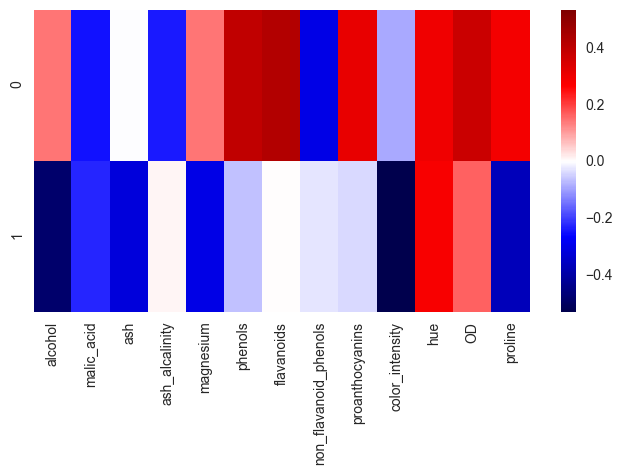

In [40]:
df_comp = pd.DataFrame(pca.components_, columns=['alcohol', 'malic_acid', 'ash', 'ash_alcalinity', 'magnesium', 'phenols', 'flavanoids', 
                            'non_flavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'OD', 'proline'])

fig  = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(111); 

sns.heatmap(df_comp, cmap='seismic', ax=axes1)

In [39]:
df = pd.DataFrame(data=np.array([x_pca[:,0],x_pca[:,1]]).transpose())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df['target'], test_size=0.5);

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1);

knn.fit(X_train,y_train);

pred = knn.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test,pred));
print("\n")

print("Classification Report")
print(classification_report(y_test,pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(knn, scaled_df, df['target'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

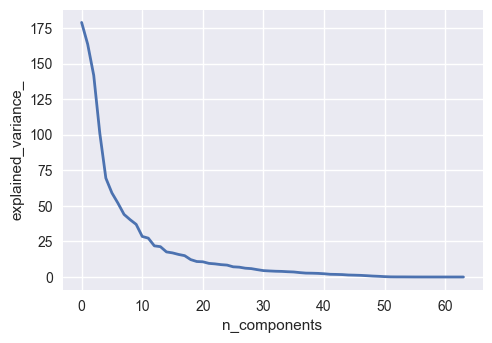

In [36]:
logistic = LogisticRegression()

pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

pca.fit(X_digits)

plt.figure(1, figsize=(6, 4), dpi=100)
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

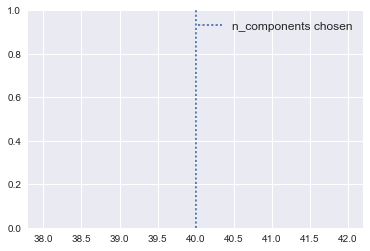

In [37]:
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

# Multi-Layer Perceptron

In [67]:
clf = MLPClassifier()

clf.fit(X_train, y_train);

pred = clf.predict(X_test);
pred_clf = clf.predict(X_test);

print("Confusion Matrix")
print(confusion_matrix(y_test, pred));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

print("Cross Validation Scores")
scores = cross_val_score(clf, train_df.drop('Survived', axis=1), train_df['Survived'],  cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Confusion Matrix
[[47  9]
 [13 21]]


Classification Report
             precision    recall  f1-score   support

          0       0.78      0.84      0.81        56
          1       0.70      0.62      0.66        34

avg / total       0.75      0.76      0.75        90



Cross Validation Scores
Accuracy: 0.73 (+/- 0.13)


In [39]:
param_grid = [{'activation': ['identity', 'logistic', 'tanh', 'relu']              }]

grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)

print('Best Score')
print(grid.best_score_)
print('\n')

#print('Mean Test Score')
#print(grid.cv_results_['mean_train_score'])
#print('\n')

print('Best Parameters')
grid.best_params_
print('\n')

print('Best Estimator')
grid.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations re

Best Score
0.808988764045


Best Parameters


Best Estimator


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [68]:
submission_mlp = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": clf.predict(test_df.values)
    })

#submission.to_csv('submissions/clf_submission.csv', index=False)

# Ensembling

In [71]:
data = np.array([pred_knn, pred_svc, pred_dtree, pred_rfc, pred_gbm, pred_lr, pred_gnb, pred_lda, pred_qda, pred_clf]).transpose() 

answers = pd.DataFrame(data=data,
                       columns = ['knn', 'svc', 'dtree', 'rfc', 'gbm', 'lr', 'gnb', 'lda', 'qda', 'clf'])

answers.head()

,knn,svc,dtree,rfc,gbm,lr,gnb,lda,qda,clf
0,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,1,1,1
4,0,1,1,1,0,1,1,1,1,1


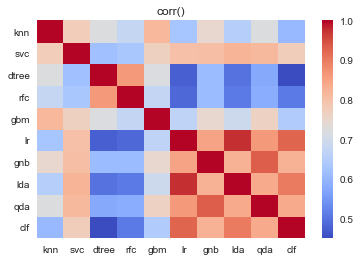

In [72]:
sns.heatmap(answers.corr(), cmap='coolwarm')
plt.title('corr()')

RFC, LR, LDA, SVC, GBM seem good candidates

In [40]:
pred = np.rint((pred_rfc + pred_lr + pred_lda + pred_svc + pred_gbm)/5)

pred

array([ 1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.])

In [47]:
pred = np.rint(((76*pred_rfc) + (72*pred_lr) + (73*pred_lda) + (79*pred_svc) + (78*pred_gbm))/(76+72+73+79+78))

print("Classification Report")
print(classification_report(y_test, pred_svc));
print("\n")

print("Classification Report")
print(classification_report(y_test, pred));
print("\n")

Classification Report
             precision    recall  f1-score   support

          0       0.74      0.92      0.82        49
          1       0.86      0.61      0.71        41

avg / total       0.79      0.78      0.77        90



Classification Report
             precision    recall  f1-score   support

          0       0.75      0.90      0.81        49
          1       0.84      0.63      0.72        41

avg / total       0.79      0.78      0.77        90





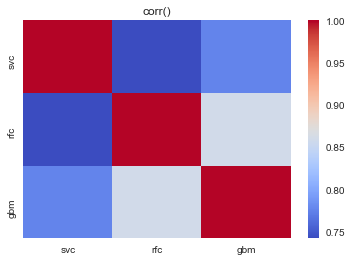

In [56]:
data = np.array([submission_svc['Survived'].values, submission_rfc['Survived'].values, submission_gbm['Survived'].values]).transpose() 

answers = pd.DataFrame(data=data,
                       columns = ['svc', 'rfc', 'gbm'])

sns.heatmap(answers.corr(), cmap='coolwarm')
plt.title('corr()')

In [63]:
survived.astype(int)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0,

In [64]:
survived = np.rint((submission_svc['Survived'].values + submission_rfc['Survived'].values + submission_gbm['Survived'].values)/3).astype(int)

submission = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": survived
    })

submission.to_csv('submissions/ensemble_submission.csv', index=False)

In [75]:
survived = np.rint((submission_svc['Survived'].values + 
                    submission_lr['Survived'].values + 
                    submission_gbm['Survived'].values + 
                    submission_gnb['Survived'].values
                   )/4).astype(int)

submission = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": survived
    })

submission.to_csv('submissions/ensemble_svc_lr_gbm_gnb_submission.csv', index=False)

79.4% - Top 27%

In [21]:
survived = np.rint((submission_svc['Survived'].values + 
                    submission_lr['Survived'].values + 
                    submission_gnb['Survived'].values
                   )/4).astype(int)

submission = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": survived
    })

submission.to_csv('submissions/ensemble_svc_lr_gnb_submission.csv', index=False)

79.9 - Top 20%

In [25]:
survived = np.rint((submission_svc['Survived'].values + 
                    submission_lr['Survived'].values + 
                    submission_gnb['Survived'].values + 
                    submission_knn['Survived'].values
                   )/4).astype(int)

submission = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": survived
    })

submission.to_csv('submissions/ensemble_svc_lr_gnb_knn_submission.csv', index=False)

In [71]:
survived = np.rint((submission_svc['Survived'].values + 
                    submission_lr['Survived'].values + 
                    submission_gnb['Survived'].values + 
                    submission_qda['Survived'].values + 
                    submission_knn['Survived'].values +
                    submission_mlp['Survived'].values
                   )/6).astype(int)

submission = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": survived
    })

submission.to_csv('submissions/ensemble_svc_lr_gnb_qda_knn_mlp_submission.csv', index=False)

75%

In [29]:
survived = np.rint((submission_svc['Survived'].values*submission_lr['Survived'].values*submission_gnb['Survived'].values)**(1/3)).astype(int)

submission = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": survived
    })

submission.to_csv('submissions/ensemble_svc_lr_gnb_geomean_submission.csv', index=False)

geometric mean of support vector machine, linear regression, gaussian naive bayes gets 77.9 %

# Neural Networks

In [41]:
np.shape(scaled_train)

(891, 7)

In [60]:
scaled_train.shape[0]

891

In [62]:
scaled_train_reshaped = scaled_train.reshape(scaled_train.shape[0] * 7)

In [63]:
# Design Model

model = Sequential()

model.add(Dense(8, activation='relu', input_dim=(891)))
model.add(Dropout(0.05))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 8)                 7136      
_________________________________________________________________
dropout_9 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_10 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 7,217
Trainable params: 7,217
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Compile

model.compile(optimizer=RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history=model.fit(scaled_train_reshaped, y_train, 
                  validation_split = 0.05, 
                  epochs=5, batch_size=16)